In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import vgg19

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [45]:
Path_style = './artistic_style.jpeg'
Path_content = './chicago.jpg'

In [63]:
device = "cpu"

In [44]:
model = models.vgg19(pretrained=True).features

In [71]:
transform = transforms.Compose([
    transforms.Resize((256,256)),  # scale imported image
    transforms.ToTensor()])

to_pil = transforms.ToPILImage()

In [72]:
def load_image(image_name):
    image = Image.open(image_name).convert('RGB')
    image = transform(image)
    return image.to(device)

In [73]:
c = load_image(Path_content)
s = load_image(Path_style)

In [62]:
c.size()

torch.Size([3, 128, 128])

In [74]:
def plot_img(content_img, style_img, title=None):
    content_image = to_pil(content_img.cpu().clone().squeeze())
    
    style_image = to_pil(style_img.cpu().clone().squeeze())
    
    fig = plt.figure(figsize = (20, 10))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(content_image, aspect="auto")
    if title is not None:
        plt.title(title[0], fontsize=30)
    ax.axis('off')
    
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(style_image, aspect="auto")
    if title is not None:
        ax.set_title(title[1], fontsize=30)
    ax.axis('off')

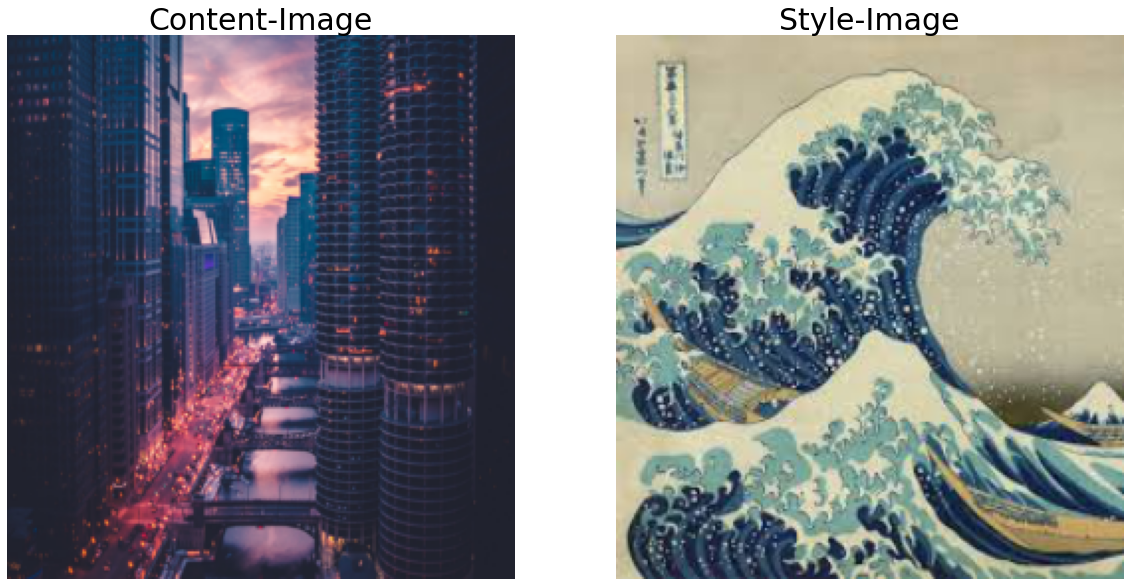

In [75]:
plot_img(c, s, title=['Content-Image', 'Style-Image'])